In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, poisson, invgamma, gamma

#Read data
data = pd.read_csv("dataexercise2.csv")
data_top = data.head() 

y = np.expand_dims(data['y'], axis=1)
x = data.drop('y', axis=1).to_numpy()

FileNotFoundError: [Errno 2] File b'dataexercise2.csv' does not exist: b'dataexercise2.csv'

In [23]:
def gradient(x,y,theta):
    return (-1.0/25)*theta.T + x.T @ (y - np.exp(x @ theta.T))
    
def hessian(x,theta):
    return -(1.0/25)*np.eye(theta.shape[1]) - (x.T @ np.diag(np.exp(x @ theta.T).flatten()) @ x)

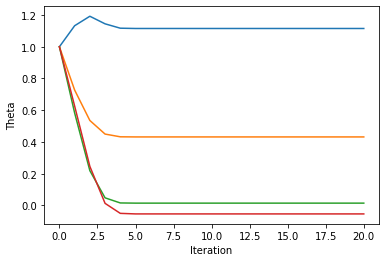

In [24]:
# Laplace approximation
#Compute MAP to find posterior mode thetaMax
#thetaMax will be the mean of approximated posterior distribution
theta = np.array([[1,1,1,1]])
allTheta = []
allTheta.append(theta)
for it in range(20):
    theta = np.array(theta - (np.linalg.inv(hessian(x,theta).T) @ gradient(x,y,theta)).T)
    allTheta.append(theta)
    
plt.figure()
allTheta = np.array(allTheta).squeeze()
for i in range(4):
    plt.plot(allTheta[:,i])

plt.xlabel("Iteration")
plt.ylabel("Theta")
    
laplaceMean = theta
H = hessian(x, laplaceMean)
laplaceCov = np.linalg.inv(-H)

In [74]:
#Markov Chain Monte-Carlo
#Metropolis algorithm

#Setup
theta = np.array([1,1,1,1])# initial value
numSamples = 1000 # number of samples to take
burningSamples = 100
thetaSamples = np.zeros((numSamples, len(theta)))
logPrior = lambda t: multivariate_normal.logpdf(t, mean=np.array([0,0,0,0]), cov=np.eye(len(t))*25)
singleLogLikelihood = lambda t, x, y: poisson.logpmf(y,np.exp(x @ t))
logLikelihood = lambda t, x, y: np.sum(singleLogLikelihood(t, x[i], y[i]) for i in range(len(y)))

In [76]:
#Metropolis algorithm
points = []
accepted = 0
sigmaProposal = 0.07 # standard deviation of gaussian proposal
for samp in range(numSamples):
    thetaNew = (theta + np.random.randn(1,4)*sigmaProposal).flatten()
    logA = logLikelihood(thetaNew,x,y) + logPrior(thetaNew) - logLikelihood(theta,x,y) - logPrior(theta)
    if np.log(np.random.rand()) <= logA:
        # accept
        if (samp > burningSamples):
            accepted = accepted + 1
        theta = thetaNew
    else:
        # reject
        pass
    thetaSamples[samp] = theta
    points.append(samp)
ratio = accepted/(numSamples-burningSamples)
print("Acceptance ratio = %.2f" % ratio)

C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Acceptance ratio = 0.38


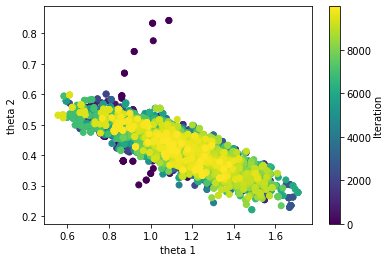

In [39]:
#Plotting

plt.scatter(thetaSamples[:,0], thetaSamples[:,1], c=points)
plt.xlabel("theta 1")
plt.ylabel("theta 2")
cbar= plt.colorbar()
cbar.set_label("Iteration", labelpad=+1)
plt.show()

In [17]:
#Get the result
finalThetaMetropolis = np.array([0.0,0.0,0.0,0.0])
print(len(thetaSamples))
for i in range(burningSamples,numSamples):
    finalThetaMetropolis += thetaSamples[i]
finalThetaMetropolis = finalThetaMetropolis/(numSamples-burningSamples)

10000


In [2]:
#Markov Chain Monte-Carlo
#Gibbs Sampling

#Setup
numSamples = 1000 # number of samples to take
burningSamples = 100
thetaZero = np.array([1,1,1,1])
sigmaSqrZero = 1
sigmaProposal = 0.07 
thetaSamples = np.zeros((numSamples+1, len(thetaZero)))
sigmaSamples = np.zeros(numSamples+1)
thetaSamples[0] = thetaZero
sigmaSamples[0] = sigmaSqrZero

# sampleSigma = lambda t, a, b: invgamma.rvs(a + 2, scale = (t@t.T + 2*b)/2)
logPriorWithSigmaSqr = lambda t, s: multivariate_normal.logpdf(t, mean=np.array([0,0,0,0]), cov=np.eye(len(t))*s)
singleLogLikelihood = lambda t, x, y: poisson.logpmf(y,np.exp(x @ t))
logLikelihood = lambda t, x, y: np.sum(singleLogLikelihood(t, x[i], y[i]) for i in range(len(y)))

In [3]:
#Gibbs sampling
points = []
points.append(0)
for i in range(1, numSamples+1):
    #Sample theta as in Metropolis
    thetaNew = (thetaSamples[i-1] + np.random.randn(1,4)*sigmaProposal).flatten()
    logA = logLikelihood(thetaNew,x,y) + logPriorWithSigmaSqr(thetaNew,sigmaSamples[i-1]) \
           - logLikelihood(thetaSamples[i-1],x,y) - logPriorWithSigmaSqr(thetaSamples[i-1],sigmaSamples[i-1])
    if np.log(np.random.rand()) <= logA:
        # accept
        thetaSamples[i] = thetaNew
    else:
        # reject
        thetaSamples[i] = thetaSamples[i-1]
        pass
    
    #Sample sigma
    a = 0.1 + 2
    b = (thetaSamples[i] @ thetaSamples[i].T + 2*0.1)/2
    sigmaSamples[i] = invgamma.rvs(a, scale=b)
    points.append(i)

C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


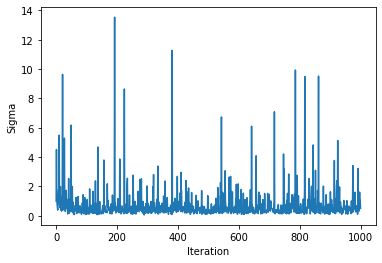

In [4]:
#Plotting
plt.plot(points, sigmaSamples)
plt.xlabel("Iteration")
plt.ylabel("Sigma")
plt.show()

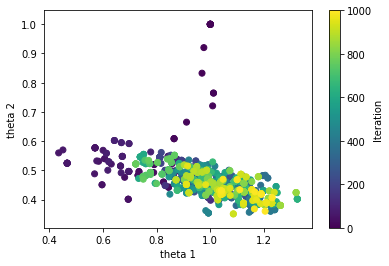

In [5]:
plt.scatter(thetaSamples[:,0], thetaSamples[:,1], c=points)
plt.xlabel("theta 1")
plt.ylabel("theta 2")
cbar= plt.colorbar()
cbar.set_label("Iteration", labelpad=+1)
plt.show()

In [14]:
finalThetaGibbs = np.array([0.0,0.0,0.0,0.0])
finalSigmaGibbs = 0
for i in range(burningSamples,numSamples):
    finalThetaGibbs += thetaSamples[i]
    finalSigmaGibbs += sigmaSamples[i]
finalThetaGibbs = finalThetaGibbs/(numSamples-burningSamples)
finalSigmaGibbs = finalSigmaGibbs/(numSamples-burningSamples)

out = x @ finalThetaGibbs.T

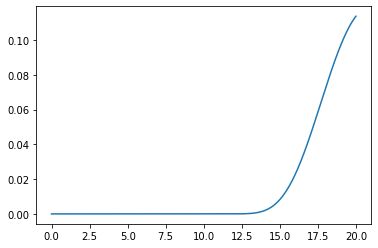

In [133]:
v = np.array([0,0,0,0])
xs = np.linspace(0,20,5000)
plt.plot(xs, gamma.pdf(xs, 1/a + 2, 2/(v@v.T + 2*b)))
plt.show()